In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split


In [2]:
root = '../../../Data/dataset/'
files = os.listdir(root)

In [3]:
# signals = np.empty((1,200))
# labels = np.empty(1)
# for csvfile in tqdm(files):
#     df = pd.read_csv(os.path.join(root, csvfile))
# #     print(df.head())
#     label = np.expand_dims(np.array(df['label']), axis = 1)
#     sigs = np.array(df.drop(['label'], axis = 1))
# #     print(label.shape, sigs.shape)
#     signals = np.vstack((signals, sigs))
#     labels = np.vstack((labels, label))
# #     break


In [4]:
# signals = np.array(signals)
# labels = np.array(labels)
signals = np.load("../../../Data/AFData/signals.npy")
labels = np.load("../../../Data/AFData/labels.npy")
print(labels.shape, signals.shape)


(1586000, 1) (1586000, 200)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(signals[1:], labels[1:],
                                                    test_size=0.2, stratify=labels[1:],
                                                    random_state=101)


In [6]:
sum(labels==1), sum(labels==0)

(array([531936]), array([1054064]))

In [7]:
del signals, labels


In [8]:
if not os.path.exists('../../../Data/AFData/signals.npy'):
    np.save('/home/karthiktiwari/Data/AFData/signals.npy', signals)
    np.save('/home/karthiktiwari/Data/AFData/labels.npy', labels)


In [9]:
class AFDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        signal = torch.Tensor(
            self.signals[idx]
        )
        label = self.labels[idx]
        return {'signal': signal, 'label': label}


In [10]:
train_data = AFDataset(X_train, y_train)
test_data = AFDataset(X_test, y_test)
train_dataloader = DataLoader(
    train_data, batch_size=128, shuffle=True, num_workers=2)
test_dataloader = DataLoader(
    test_data, batch_size=128, shuffle=False, num_workers=2)


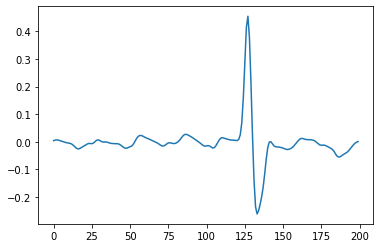

In [11]:
plt.plot(train_data[1000]['signal'].numpy())


In [12]:
# plt.plot(data[0]['signal'].numpy())
# print(labels[1])
# print(np.unique(labels[1:]))


In [13]:
class AFModel(nn.Module):
    def __init__(self):
        super(AFModel, self).__init__()
        # self.attn = nn.MultiheadAttention(
        #     embed_dim=128, num_heads=1, batch_first=True)
        self.lstm1 = nn.LSTM(1, 32, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(64, 64, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(25600, 512)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(dim=2)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        # x, _ = self.attn(x, x, x)
        x = self.drop(x)
        b, _, _ = x.shape
        x = x.reshape(b, -1)
        x = self.fc1(x)
        x = self.relu(x)
        return x


In [14]:
class AFConvNet(nn.Module):
    def __init__(self):
        super(AFConvNet, self).__init__()
        # self.attn = nn.MultiheadAttention(
        #     embed_dim=64, num_heads=1, batch_first=True)
        self.conv1 = nn.Conv1d(1, 32, 16, padding=16, stride=2)
        self.conv2 = nn.Conv1d(32, 64, 8, padding=16, stride=2)
        self.fc1 = nn.Linear(4288, 512)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        # x = x.permute(0, 2, 1)
        # x, _ = self.attn(x, x, x)
        x = self.drop(x)
        b, _, _ = x.shape
        x = x.reshape(b, -1)
        x = self.fc1(x)
        x = self.relu(x)
        return x


In [23]:
class AFConvLSTMNet(nn.Module):
    def __init__(self):
        super(AFConvLSTMNet, self).__init__()
        self.convBlock = AFConvNet()
        self.LSTMBlock = AFModel()
        self.fc = nn.Linear(1024, 1)

    def forward(self, x):
        x_copy = x.clone()
        x = self.convBlock(x)
        x_copy = self.LSTMBlock(x_copy)
        x = torch.hstack((x, x_copy))
        x = self.fc(x)
        return x


In [24]:
def train_epoch(model, loader, opt, loss_fn, device, size, threshold=0.5):
    total_loss = 0
    count = 0
    model.train()
    for data in tqdm(loader):
        X = data['signal'].float().to(device)
        y = data['label'].float().to(device)

        output = model(X)

        loss = loss_fn(output, y)
        total_loss += loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()

        preds = output.squeeze(dim=1)
        preds = torch.sigmoid(preds)
        preds = torch.tensor(
            [1 if x > threshold else 0 for x in preds]).to(device)

        gt = y.squeeze(dim=1)

        count += (preds == gt).sum()

    return total_loss, count / size, output


def val_epoch(model, loader, loss_fn, device, size, threshold=0.5):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for data in tqdm(loader):
            X = data['signal'].float().to(device)
            y = data['label'].float().to(device)

            output = model(X)

            loss = loss_fn(output, y)
            total_loss += loss.item()

            preds = output.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            preds = torch.tensor(
                [1 if x > threshold else 0 for x in preds]).to(device)

            gt = y.squeeze(dim=1)

            count += (preds == gt).sum()

    return total_loss, count / size


In [25]:
device = 'cuda'
# model = AFModel().to(device)
model = AFConvLSTMNet().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=3, gamma=0.7)
loss_fn = nn.BCEWithLogitsLoss().to(device)


In [29]:
epochs = 1

for epoch in range(epochs):

    train_loss, train_acc, op = train_epoch(
        model,
        train_dataloader,
        optimiser,
        loss_fn,
        device,
        len(y_train),
    )

    val_loss, val_acc = val_epoch(
        model,
        test_dataloader,
        loss_fn,
        device,
        len(y_test)
    )

    print(f'Epoch: {epoch + 1}')
    print(f'Train Accuaracy: {train_acc} Train Loss: {train_loss}')
    print(f'Val Accuaracy: {val_acc} Val Loss: {val_loss}')
    print()


100%|██████████| 2479/2479 [00:47<00:00, 51.87it/s]

Epoch: 1
Train Accuaracy: 0.9745704531669617 Train Loss: 647.4333880324848
Val Accuaracy: 0.9751355648040771 Val Loss: 156.35274312272668



In [27]:
model_name = input()
torch.save(model.state_dict(), '{}.pth'.format(model_name))


In [17]:
model.load_state_dict(torch.load('AttnBasedLSTM.pth'))


RuntimeError: Error(s) in loading state_dict for AFConvLSTMNet:
	Missing key(s) in state_dict: "LSTMBlock.lstm1.weight_ih_l0_reverse", "LSTMBlock.lstm1.weight_hh_l0_reverse", "LSTMBlock.lstm1.bias_ih_l0_reverse", "LSTMBlock.lstm1.bias_hh_l0_reverse", "LSTMBlock.lstm2.weight_ih_l0_reverse", "LSTMBlock.lstm2.weight_hh_l0_reverse", "LSTMBlock.lstm2.bias_ih_l0_reverse", "LSTMBlock.lstm2.bias_hh_l0_reverse". 
	size mismatch for LSTMBlock.attn.in_proj_weight: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([384, 128]).
	size mismatch for LSTMBlock.attn.in_proj_bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for LSTMBlock.attn.out_proj.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for LSTMBlock.attn.out_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for LSTMBlock.lstm2.weight_ih_l0: copying a param with shape torch.Size([256, 32]) from checkpoint, the shape in current model is torch.Size([256, 64]).
	size mismatch for LSTMBlock.fc1.weight: copying a param with shape torch.Size([512, 12800]) from checkpoint, the shape in current model is torch.Size([512, 25600]).

In [30]:
model.eval()
threshold = 0.5
count = 0
gts = []
model_preds = []
with torch.no_grad():
    for data in tqdm(test_dataloader):
        X = data['signal'].float().to(device)
        y = data['label'].float().to(device)

        output = model(X)
        preds = output.squeeze(dim=1)
        preds = torch.sigmoid(preds)
        preds = torch.tensor(
            [1 if x > threshold else 0 for x in preds]).to(device)
        model_preds.extend(preds.detach().cpu().numpy())
        gts.extend(y.detach().cpu().numpy())
        gt = y.squeeze(dim=1)

        count += (preds == gt).sum()

print("Accuracy on Test Data is {0:.4g}%".format(
    (count.item()*100)/len(y_test)))


100%|██████████| 2479/2479 [00:46<00:00, 53.38it/s]

Accuracy on Test Data is 97.51%


In [27]:
from sklearn.metrics import classification_report
print(classification_report(gts, model_preds))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    210813
         1.0       0.98      0.97      0.98    106387

    accuracy                           0.98    317200
   macro avg       0.98      0.98      0.98    317200
weighted avg       0.98      0.98      0.98    317200



In [ ]:
# cm = confusion_matrix(np.array(model_preds), np.array(gts))
# precision_score = precision_score(np.array(model_preds), np.array(gts))
# print('precision_score :\n',precision_score)
# recall_score = recall_score(np.array(model_preds), np.array(gts))
# print('recall_score :\n',recall_score)
# f1_score = f1_score(np.array(model_preds), np.array(gts))
# print('f1_score :\n',f1_score)
# tp, fp, tn, fn = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
# print("Confusion Matrix: TP {}, FP {}, TN {}, FN {}".format(tp,fp,tn,fn))

# total = sum(sum(cm))
# # from confusion matrix calculate accuracy
# accuracy = (cm[0, 0]+cm[1, 1])/total
# print('Accuracy : ', accuracy)

# sensitivity = cm[0, 0]/(cm[0, 0]+cm[0, 1])
# print('Sensitivity : ', sensitivity)

# specificity = cm[1, 1]/(cm[1, 0]+cm[1, 1])
# print('Specificity : ', specificity)